In [17]:
import pybar.pybar_tom as pybar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib import cm
import pandas as pd
from tqdm import tqdm
import functions as f
from pathlib import Path
import time

In [4]:
psi = np.deg2rad(50)
to_Myr = 9.78462
bar_length = 2.6
err_vr = 0.1
err_rho = 0.05

In [5]:
t = 20
case = 'perfectdisk'
FIG_DIR = Path('./../figures/')

In [63]:
result = []
for i in np.deg2rad(np.linspace(5, 88, 30)):
    for deltaPA in np.geomspace(1e-1, 5, 30):
        X, Y, VX, VY, RHO = np.load(f'./../simulation/simulation/output_npy/strongbar/data_{t}.npy')
        VX  = np.zeros_like(VX)
        VY  = np.zeros_like(VX)
        RHO = np.ones_like(RHO) * np.exp(- np.sqrt(10) / 3 * np.sqrt (X ** 2 + Y ** 2))
        
        X, Y, VX, VY = f.rotate_bar(psi, X, Y, VX, VY)
        VX, VY = f.add_solid_body_rotation(X, Y, VX, VY, 0.4)
        X, Y, VR = f.incline_galaxy(i, X, Y, VX, VY)
        
        step_final   = 0.1
        step_initial = 0.07

        RHO_array = RHO.copy()
        VR_array  = VR.copy()
        x_center_array, y_center_array = X.copy(), Y.copy()
        
        VR_err = err_vr * np.ones_like(VR_array)
        RHO_err = err_rho * RHO_array

        VR_array, RHO_array = f.add_uncertanties(VR_array, RHO_array, err_vr, err_rho * RHO_array)

        pa_uncertainty = deltaPA#np.random.uniform(-2, 2)
        x_center_array, y_center_array, _, _ = f.rotate_bar(np.deg2rad(pa_uncertainty), x_center_array, y_center_array, 0, 0)
        bar = pybar.mybar(Flux=RHO_array, Flux_err=RHO_err,
                  Velocity=VR_array, Velocity_err=VR_err,
                  Yin=y_center_array, Xin=x_center_array,
                  slit_width=step_final,
                  inclin=np.rad2deg(i), PAnodes=-90, beta=np.rad2deg(psi), if_symmetrize=False)

        bar.tremaine_weinberg()
        omega_bar, omega_bar_err, c, c_err, x_tw, v_tw, x_tw_err, v_tw_err = f.fit(bar)
        result.append([np.rad2deg(i), deltaPA, omega_bar, c])

In [64]:
result = np.array(result)

In [8]:
# set the colormap and centre the colorbar
class MidpointNormalize(mc.Normalize):
    """Normalise the colorbar."""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mc.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [9]:
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021/bin/universal-darwin'
#print(os.getenv("PATH"))

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rc('text', usetex=True)

In [82]:
a = result[result[:,0] == 65.10344827586206,:]

In [105]:
def firstNonNan(listfloats):
    for item in listfloats:
        if np.isnan(item).any() == False:
            return item[1], item[2]
    return np.nan, np.nan

In [106]:
PA_inc = []
for inc in np.unique(result[:,0]):
    subset = result[result[:,0] == inc]
    deltaPA_i, omega_i = firstNonNan(subset)
    PA_inc.append([inc, deltaPA_i, omega_i])
PA_inc = np.array(PA_inc)

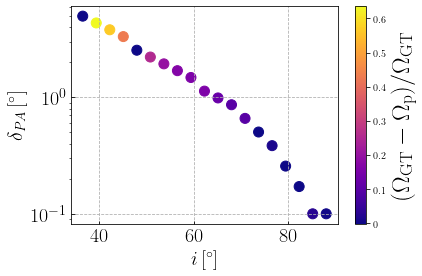

In [117]:
levels = np.linspace(np.nanmin(result[:,2] - 0.4), np.nanmax(result[:,2] - 0.4), 101)
norm = MidpointNormalize(np.nanmin(result[:,2] - 0.4), np.nanmax(result[:,2] - 0.4), 0.0)

fig, ax = plt.subplots(figsize=(6, 4))

sc = ax.scatter(PA_inc[:,0], PA_inc[:,1], c=(PA_inc[:,2] - 0.4) /0.4, 
                cmap='plasma', marker='o', s=100)
ax.grid(ls='dashed')
ax.tick_params(labelsize=20, direction='in')
ax.set_xlabel(r'$i\, \rm  [^\circ$]', fontsize=20)
ax.set_ylabel(r'$\delta_{PA} \, \rm[^\circ$]', fontsize=20)
# ax.set_ylim(0, 90)
# ax.set_xlim(0, 90)
ax.set_yscale('log')
# ax.set_aspect('1')
# ax.set_title(r'$V_{radial}$', fontsize=20)
cbar = plt.colorbar(sc, format='%g')
cbar.set_label(label=r'$\rm  (\Omega_{GT} - \Omega_p)/\Omega_{GT}$', size=25)
plt.savefig(FIG_DIR / f'omega_fit_i_deltaPA_{case}_scatter.png', bbox_inches='tight', dpi=300)

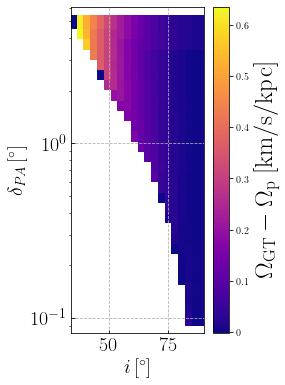

In [75]:
levels = np.linspace(np.nanmin(result[:,2] - 0.4), np.nanmax(result[:,2] - 0.4), 101)
norm = MidpointNormalize(np.nanmin(result[:,2] - 0.4), np.nanmax(result[:,2] - 0.4), 0.0)

fig, ax = plt.subplots(figsize=(3, 6))

sc = ax.scatter(result[:,0], result[:,1], c=(result[:,2] - 0.4) /0.4, 
                cmap='plasma', marker='s', s=180)
ax.grid(ls='dashed')
ax.tick_params(labelsize=20, direction='in')
ax.set_xlabel(r'$i\, \rm  [^\circ$]', fontsize=20)
ax.set_ylabel(r'$\delta_{PA} \, \rm[^\circ$]', fontsize=20)
# ax.set_ylim(0, 90)
# ax.set_xlim(0, 90)
ax.set_yscale('log')
# ax.set_aspect('1')
# ax.set_title(r'$V_{radial}$', fontsize=20)
cbar = plt.colorbar(sc, format='%g')
cbar.set_label(label=r'$\rm  \Omega_{GT} - \Omega_p  \ [km/s/kpc]$', size=25)
plt.savefig(FIG_DIR / f'omega_fit_i_deltaPA_{case}.png', bbox_inches='tight', dpi=300)